In [16]:
import requests
import pandas as pd
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA


In [29]:
import requests
import pandas as pd
import os

# Create the directory if it doesn't exist
if not os.path.exists('Stock-ML'):
    os.makedirs('Stock-ML')

def fetch_historical_data(coin_id, days):
    url = f'https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart'
    params = {
        'vs_currency': 'usd',
        'days': days,
        'interval': 'daily'  # You can change this to 'monthly' if available
    }
    response = requests.get(url, params=params)
    data = response.json()
    return data

def parse_price_data(data):
    prices = data['prices']
    df = pd.DataFrame(prices, columns=['timestamp', 'price'])
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.drop('timestamp', axis=1, inplace=True)
    return df

def preprocess_data(df):
    df.ffill(inplace=True)  # Forward fill to handle missing values
    df['7_day_avg'] = df['price'].rolling(window=7).mean()  # 7-day moving average
    df['monthly_change'] = df['price'].pct_change(periods=30)  # Monthly percentage change
    df.set_index('date', inplace=True)  # Set 'date' as the index
    return df

# Example usage
coin_id = 'bitcoin'  # Change this to the coin you want to fetch
days = '365'  # Number of days of historical data

data = fetch_historical_data(coin_id, days)
df = parse_price_data(data)
df = preprocess_data(df)

# Save the data to a CSV file
df.to_csv(f'Stock-ML/{coin_id}_historical_data.csv')


## Step 2: Data Preprocessing

This step involves loading and preprocessing the historical price data for a cryptocurrency:

- **Load Data**: We load the historical price data from a CSV file into a pandas DataFrame.
- **Convert Date Column**: We convert the 'date' column to a datetime format and set it as the index of the DataFrame. This is important for time series analysis.
- **Handle Missing Values**: We use forward filling to handle any missing values in the data. This ensures that our time series is continuous without any gaps.
- **Feature Engineering**:
    - We calculate a 7-day moving average (`7_day_avg`) to smooth out short-term fluctuations and highlight longer-term trends.
    - We compute the monthly percentage change (`monthly_change`) to capture the monthly price movement.
- **Save Preprocessed Data**: The preprocessed data is saved to a new CSV file for further analysis.

The first few rows of the preprocessed DataFrame are displayed to verify the preprocessing steps.


In [30]:
# Cell 2: Data Preprocessing
import pandas as pd

# Load the data
df = pd.read_csv(f'Stock-ML/{coin_id}_historical_data.csv')

# Convert 'date' column to datetime if it's not already
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    # Set 'date' as the index
    df.set_index('date', inplace=True)

# Additional preprocessing steps (e.g., handling missing values, feature engineering)
df.ffill(inplace=True)  # Forward fill to handle missing values using ffill()
df['7_day_avg'] = df['price'].rolling(window=7).mean()  # 7-day moving average
df['monthly_change'] = df['price'].pct_change(periods=30)  # Monthly percentage change

# Save the preprocessed data
df.to_csv(f'Stock-ML/{coin_id}_preprocessed_data.csv', index=True)

# Print the first few rows of the preprocessed DataFrame
print(df.head())




                   price  7_day_avg  monthly_change
date                                               
2023-03-08  22217.209885        NaN             NaN
2023-03-09  21712.651194        NaN             NaN
2023-03-10  20376.320007        NaN             NaN
2023-03-11  20195.228950        NaN             NaN
2023-03-12  20521.556152        NaN             NaN


## Step 3: Define Functions for LSTM Model Building and Evaluation

In this step, we define two functions to facilitate the building and evaluation of our LSTM neural network model for time series forecasting.

- `create_dataset`: This function takes a time series dataset and a `look_back` parameter to create input-output pairs for training the LSTM model. For each input-output pair, the input is a sequence of `look_back` consecutive values, and the output is the next value in the series.

- `build_and_evaluate_lstm_model`: This function takes the preprocessed time series data, splits it into training and testing sets, and then builds, trains, and evaluates an LSTM model. The model consists of two LSTM layers and a dense output layer. The function returns the trained model, the predictions on the test set, the actual values from the test set, and the mean squared error (MSE) of the predictions.


In [20]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

def build_and_evaluate_lstm_model(data, look_back=60, epochs=10, batch_size=32):
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))

    # Split the data into training and testing sets
    train_size = int(len(scaled_data) * 0.8)
    train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

    # Create the training and testing datasets
    X_train, Y_train = create_dataset(train_data, look_back)
    X_test, Y_test = create_dataset(test_data, look_back)

    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    # Compile and train the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=2)

    # Make predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Invert predictions to original scale
    train_predict = scaler.inverse_transform(train_predict)
    Y_train_inv = scaler.inverse_transform([Y_train])
    test_predict = scaler.inverse_transform(test_predict)
    Y_test_inv = scaler.inverse_transform([Y_test])

    # Calculate mean squared error
    mse = mean_squared_error(Y_test_inv[0], test_predict[:,0])

    return model, test_predict, Y_test_inv[0], mse


## Analysis of Multiple Cryptocurrencies

In this step, we loop through a list of cryptocurrency names and perform the following actions for each cryptocurrency:

- Fetch historical price data using the `fetch_historical_data` function.
- Parse and preprocess the data using the `parse_price_data` and `preprocess_data` functions.
- Build, train, and evaluate an LSTM model on the preprocessed data using the `build_and_evaluate_lstm_model` function. The model's performance is assessed based on the Mean Squared Error (MSE) metric.
- Plot the model's predictions against the actual prices to visually inspect the model's forecasting accuracy.

This loop allows us to apply the same analysis and modeling process to multiple cryptocurrencies, providing insights into their price dynamics and the predictive capabilities of LSTM models.


Analyzing bitcoin...
Epoch 1/10
98/98 - 25s - loss: 0.0035 - 25s/epoch - 251ms/step
Epoch 2/10
98/98 - 7s - loss: 6.5635e-04 - 7s/epoch - 76ms/step
Epoch 3/10
98/98 - 9s - loss: 5.5808e-04 - 9s/epoch - 87ms/step
Epoch 4/10
98/98 - 9s - loss: 5.0129e-04 - 9s/epoch - 93ms/step
Epoch 5/10
98/98 - 6s - loss: 4.4776e-04 - 6s/epoch - 66ms/step
Epoch 6/10
98/98 - 6s - loss: 3.8822e-04 - 6s/epoch - 63ms/step
Epoch 7/10
98/98 - 5s - loss: 3.2924e-04 - 5s/epoch - 47ms/step
Epoch 8/10
98/98 - 4s - loss: 3.1794e-04 - 4s/epoch - 45ms/step
Epoch 9/10
98/98 - 4s - loss: 2.8163e-04 - 4s/epoch - 42ms/step
Epoch 10/10
98/98 - 4s - loss: 3.1906e-04 - 4s/epoch - 45ms/step
23/23 [==============================] - 1s 20ms/step
Mean Squared Error for bitcoin: 2855576.2448372687


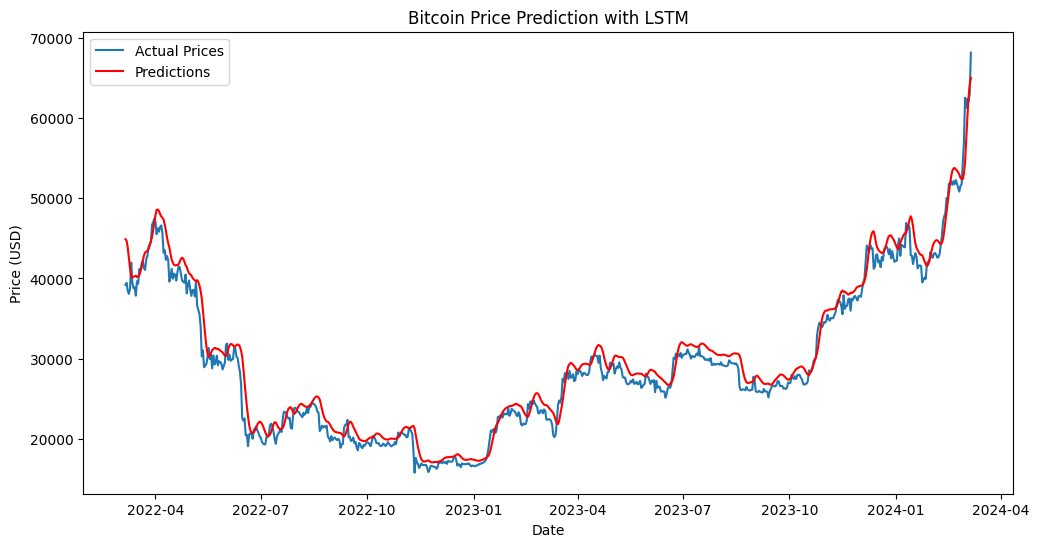

Analyzing ethereum...
Epoch 1/10
77/77 - 10s - loss: 0.0073 - 10s/epoch - 132ms/step
Epoch 2/10
77/77 - 3s - loss: 0.0013 - 3s/epoch - 38ms/step
Epoch 3/10
77/77 - 3s - loss: 0.0010 - 3s/epoch - 42ms/step
Epoch 4/10
77/77 - 3s - loss: 8.6811e-04 - 3s/epoch - 45ms/step
Epoch 5/10
77/77 - 4s - loss: 8.5185e-04 - 4s/epoch - 52ms/step
Epoch 6/10
77/77 - 4s - loss: 7.0816e-04 - 4s/epoch - 54ms/step
Epoch 7/10
77/77 - 4s - loss: 5.7075e-04 - 4s/epoch - 53ms/step
Epoch 8/10
77/77 - 5s - loss: 5.6809e-04 - 5s/epoch - 69ms/step
Epoch 9/10
77/77 - 5s - loss: 5.8267e-04 - 5s/epoch - 71ms/step
Epoch 10/10
77/77 - 4s - loss: 5.1082e-04 - 4s/epoch - 47ms/step
18/18 [==============================] - 1s 23ms/step
Mean Squared Error for ethereum: 7691.4016418151205


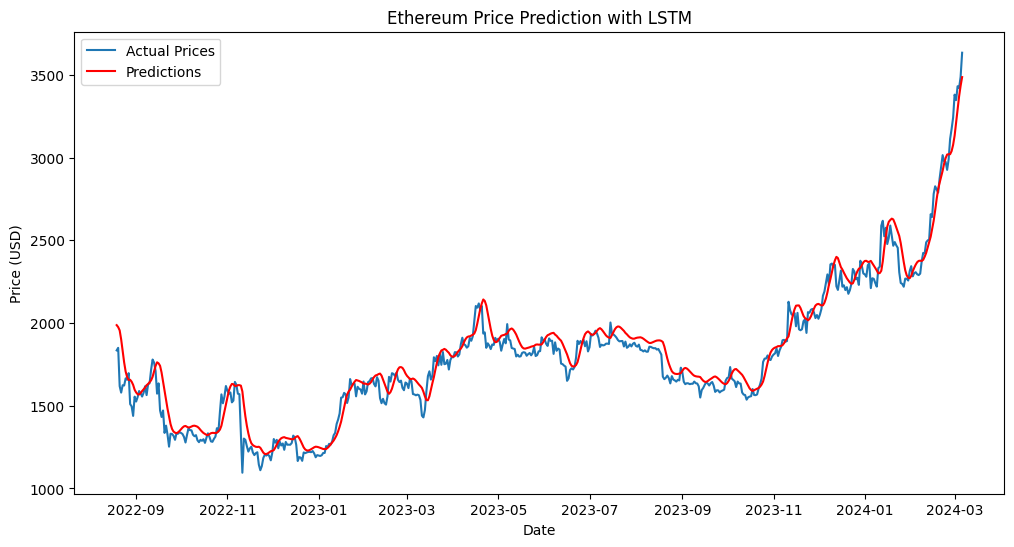

Analyzing tether...
Epoch 1/10
80/80 - 74s - loss: 0.0118 - 74s/epoch - 920ms/step
Epoch 2/10
80/80 - 8s - loss: 2.7824e-04 - 8s/epoch - 101ms/step
Epoch 3/10
80/80 - 10s - loss: 2.7952e-04 - 10s/epoch - 129ms/step
Epoch 4/10
80/80 - 20s - loss: 2.7594e-04 - 20s/epoch - 255ms/step
Epoch 5/10
80/80 - 20s - loss: 2.7406e-04 - 20s/epoch - 250ms/step
Epoch 6/10
80/80 - 20s - loss: 2.7958e-04 - 20s/epoch - 253ms/step
Epoch 7/10
80/80 - 15s - loss: 2.7692e-04 - 15s/epoch - 192ms/step
Epoch 8/10
80/80 - 10s - loss: 2.7380e-04 - 10s/epoch - 123ms/step
Epoch 9/10
80/80 - 8s - loss: 2.7468e-04 - 8s/epoch - 101ms/step
Epoch 10/10
80/80 - 6s - loss: 2.8001e-04 - 6s/epoch - 73ms/step
19/19 [==============================] - 1s 27ms/step
Mean Squared Error for tether: 6.400889735741608e-06


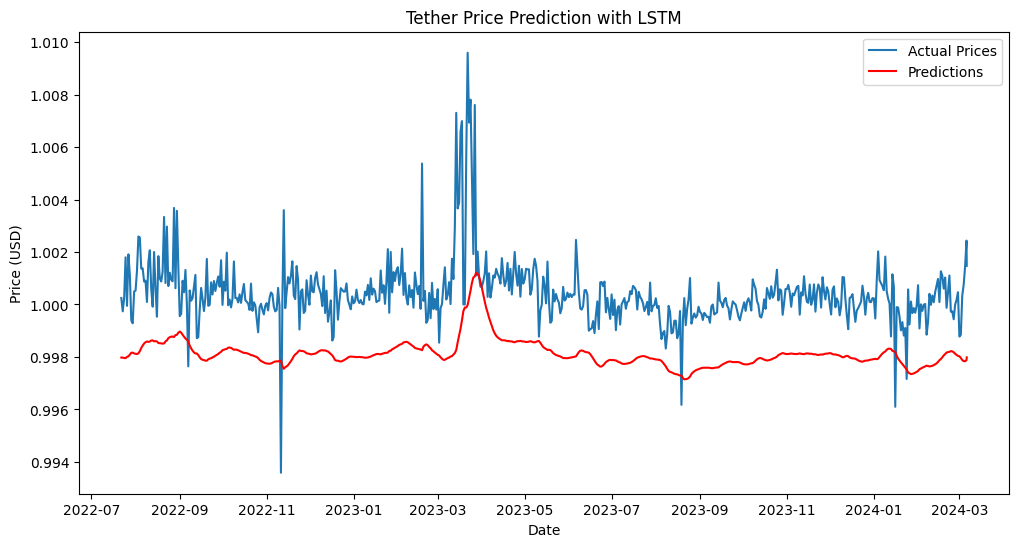

Analyzing binancecoin...
Epoch 1/10
58/58 - 13s - loss: 0.0175 - 13s/epoch - 221ms/step
Epoch 2/10
58/58 - 3s - loss: 0.0019 - 3s/epoch - 60ms/step
Epoch 3/10
58/58 - 3s - loss: 0.0017 - 3s/epoch - 53ms/step
Epoch 4/10
58/58 - 4s - loss: 0.0014 - 4s/epoch - 69ms/step
Epoch 5/10
58/58 - 4s - loss: 0.0013 - 4s/epoch - 70ms/step
Epoch 6/10
58/58 - 3s - loss: 0.0011 - 3s/epoch - 57ms/step
Epoch 7/10
58/58 - 3s - loss: 0.0010 - 3s/epoch - 53ms/step
Epoch 8/10
58/58 - 3s - loss: 9.2529e-04 - 3s/epoch - 55ms/step
Epoch 9/10
58/58 - 4s - loss: 9.4094e-04 - 4s/epoch - 66ms/step
Epoch 10/10
58/58 - 4s - loss: 8.9966e-04 - 4s/epoch - 68ms/step
13/13 [==============================] - 0s 23ms/step
Mean Squared Error for binancecoin: 377.19795141016533


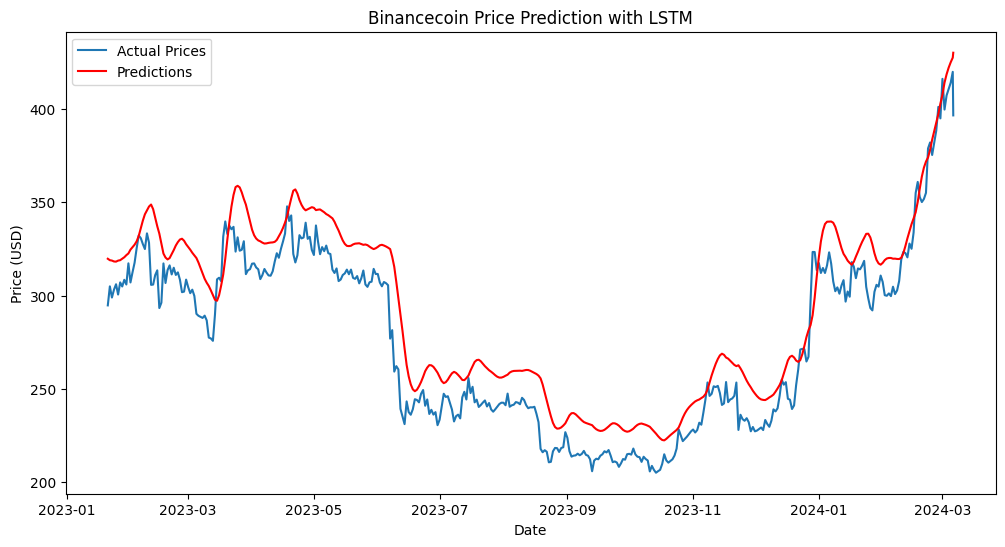

Analyzing solana...
Epoch 1/10
34/34 - 15s - loss: 0.0131 - 15s/epoch - 436ms/step
Epoch 2/10
34/34 - 2s - loss: 0.0021 - 2s/epoch - 59ms/step
Epoch 3/10
34/34 - 2s - loss: 0.0018 - 2s/epoch - 45ms/step
Epoch 4/10
34/34 - 2s - loss: 0.0015 - 2s/epoch - 59ms/step
Epoch 5/10
34/34 - 3s - loss: 0.0018 - 3s/epoch - 85ms/step
Epoch 6/10
34/34 - 2s - loss: 0.0016 - 2s/epoch - 58ms/step
Epoch 7/10
34/34 - 2s - loss: 0.0014 - 2s/epoch - 53ms/step
Epoch 8/10
34/34 - 2s - loss: 0.0013 - 2s/epoch - 49ms/step
Epoch 9/10
34/34 - 2s - loss: 0.0013 - 2s/epoch - 56ms/step
Epoch 10/10
34/34 - 2s - loss: 0.0011 - 2s/epoch - 73ms/step
8/8 [==============================] - 1s 109ms/step
Mean Squared Error for solana: 55.86429197790102


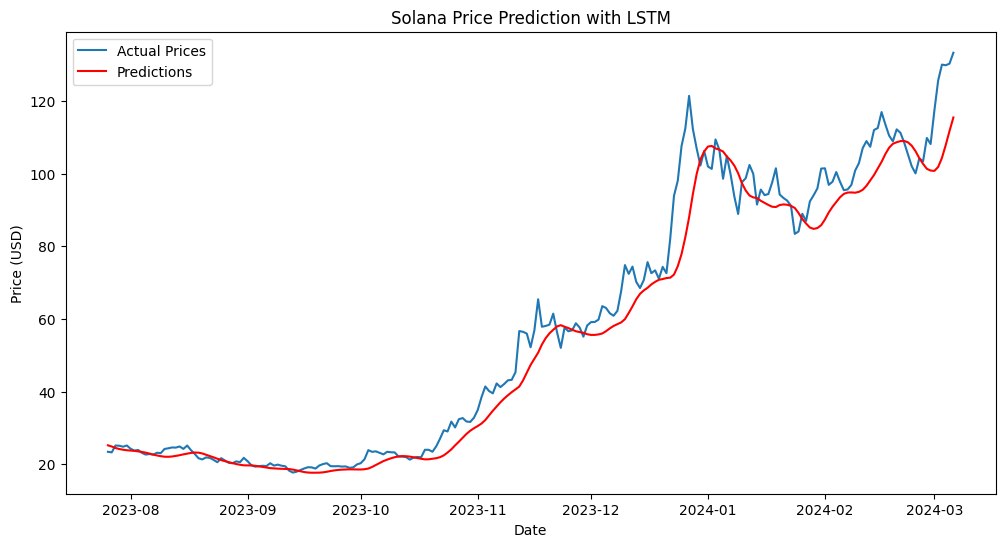

In [31]:
cryptos = ['bitcoin', 'ethereum', 'tether', 'binancecoin', 'solana']

for crypto in cryptos:
    print(f"Analyzing {crypto}...")
    data = fetch_historical_data(crypto, days='max')  # Specify the 'days' argument here
    df = parse_price_data(data)
    df_preprocessed = preprocess_data(df)

    # Build, train, and evaluate LSTM model
    model, predictions, actuals, mse = build_and_evaluate_lstm_model(df_preprocessed['price'].values)
    print(f"Mean Squared Error for {crypto}: {mse}")

    # Plot predictions vs actual prices
    plt.figure(figsize=(12, 6))
    plt.plot(df_preprocessed.index[-len(predictions):], actuals, label='Actual Prices')
    plt.plot(df_preprocessed.index[-len(predictions):], predictions, label='Predictions', color='red')
    plt.title(f'{crypto.capitalize()} Price Prediction with LSTM')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()



## Data Visualization

In this step, we define a function `plot_crypto_data` to visualize various aspects of the cryptocurrency data:

- **Price Time Series**: The first plot shows the price of the cryptocurrency over time. This helps us understand the overall trend and volatility of the market.
- **7-Day Moving Average**: The second plot shows the 7-day moving average of the price. This smoothens out short-term fluctuations and highlights longer-term trends.
- **Monthly Percentage Change**: The third plot shows the monthly percentage change in price. This provides insights into the monthly performance of the cryptocurrency.

The function takes two arguments: the preprocessed DataFrame (`df`) and the name of the cryptocurrency (`crypto_name`). It then creates three plots for the given cryptocurrency data.

By visualizing the data, we can gain a better understanding of the market dynamics and identify patterns that may inform our predictive modeling.


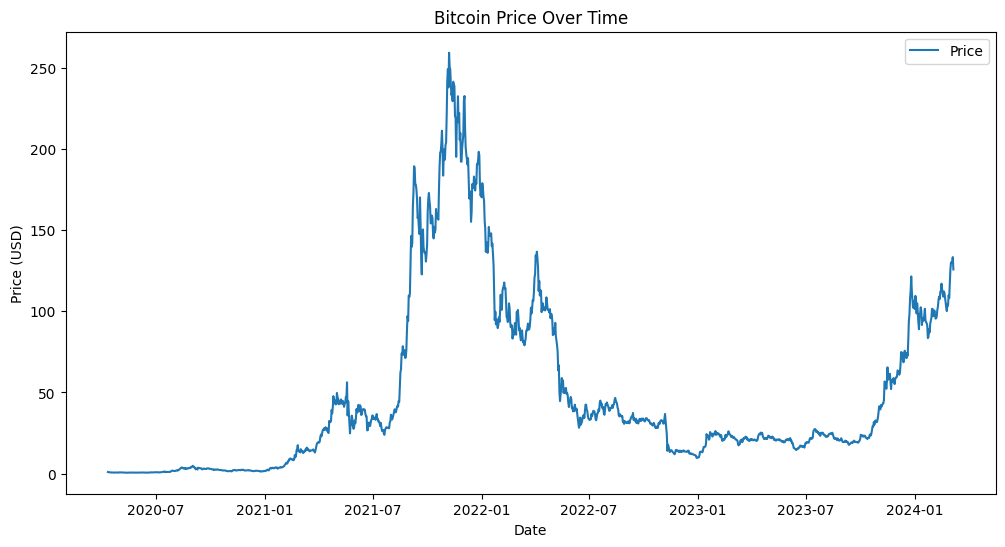

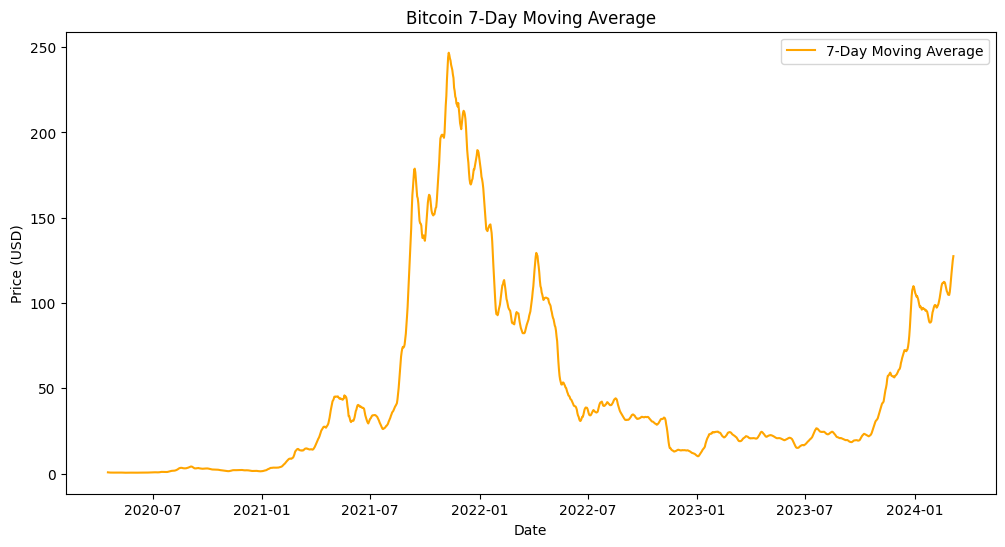

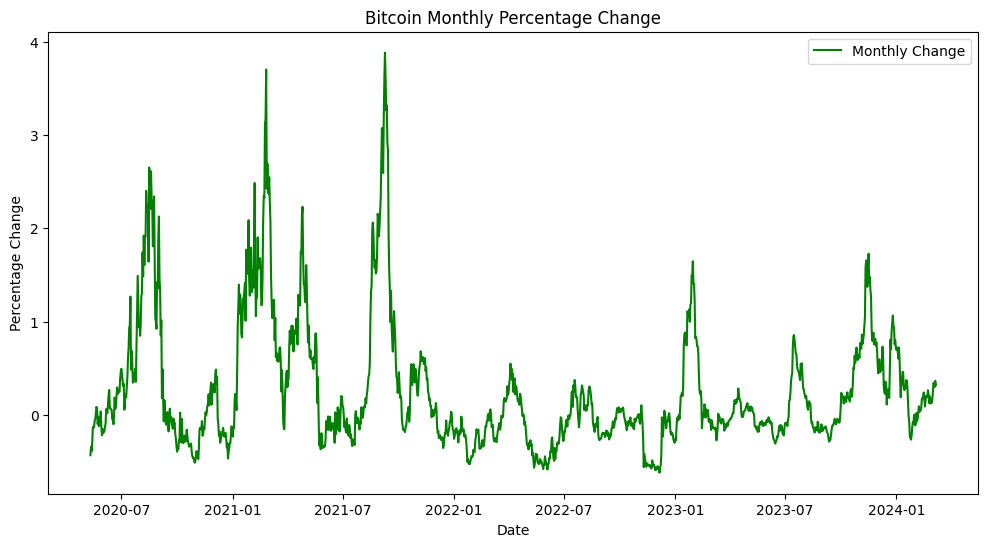

In [22]:
# Cell 3: Data Preprocessing - Convert Date Column and Set Index
import matplotlib.pyplot as plt

def plot_crypto_data(df, crypto_name):
    # Plot the price time series
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['price'], label='Price')
    plt.title(f'{crypto_name.capitalize()} Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

    # Plot the 7-day moving average
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['7_day_avg'], label='7-Day Moving Average', color='orange')
    plt.title(f'{crypto_name.capitalize()} 7-Day Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

    # Plot the monthly percentage change
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['monthly_change'], label='Monthly Change', color='green')
    plt.title(f'{crypto_name.capitalize()} Monthly Percentage Change')
    plt.xlabel('Date')
    plt.ylabel('Percentage Change')
    plt.legend()
    plt.show()

# Example usage
plot_crypto_data(df, 'bitcoin')


## Analyzing Multiple Cryptocurrencies and Plotting Data

In this step, we loop through a list of selected cryptocurrencies and perform the following actions for each one:

- **Fetch Historical Data**: We use the `fetch_historical_data` function to fetch historical price data for the cryptocurrency from the CoinGecko API.
- **Parse and Preprocess Data**: The raw data is then parsed and preprocessed using the `parse_price_data` and `preprocess_data` functions. This includes converting the date column to datetime format, setting it as the index, forward filling missing values, and calculating additional features like the 7-day moving average and monthly percentage change.
- **Plot Data**: We use the `plot_crypto_data` function to visualize the price time series, 7-day moving average, and monthly percentage change for each cryptocurrency. This helps us understand the historical price trends and market behavior of each cryptocurrency.

By analyzing and visualizing data for multiple cryptocurrencies, we can compare their market dynamics and identify patterns that may be useful for predictive modeling.


Analyzing bitcoin...


C:\Users\samin\AppData\Local\Temp\ipykernel_10920\3460888346.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill to handle missing values


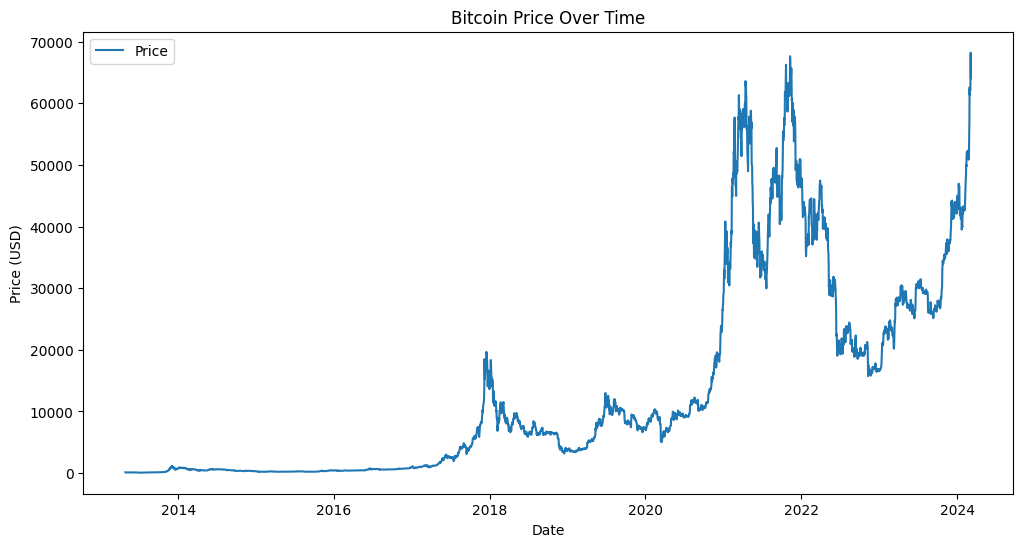

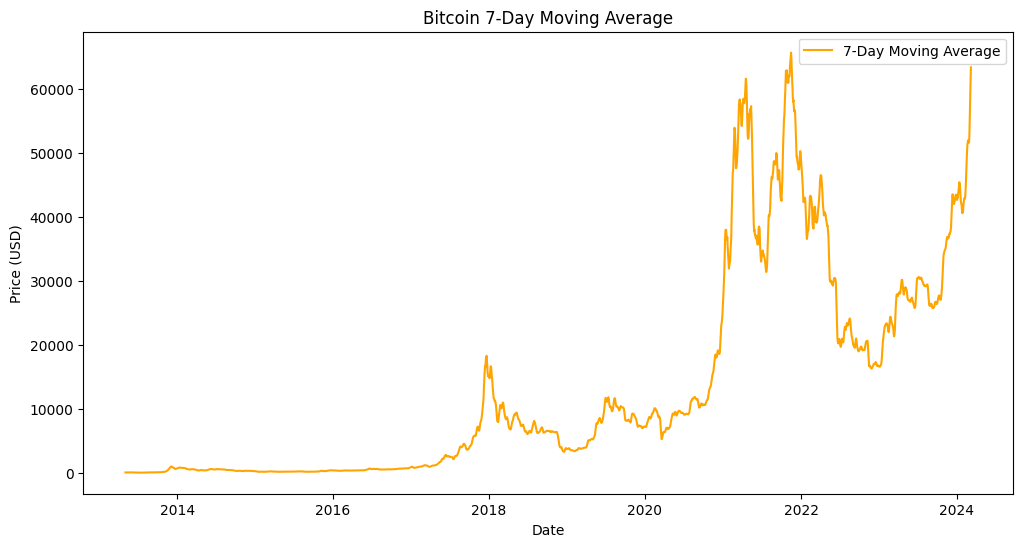

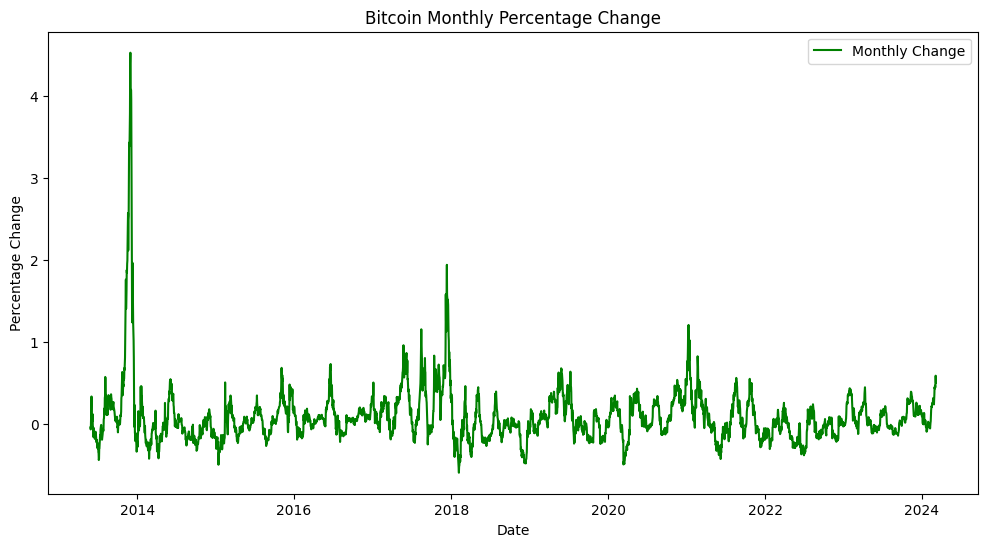

Analyzing ethereum...


C:\Users\samin\AppData\Local\Temp\ipykernel_10920\3460888346.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill to handle missing values


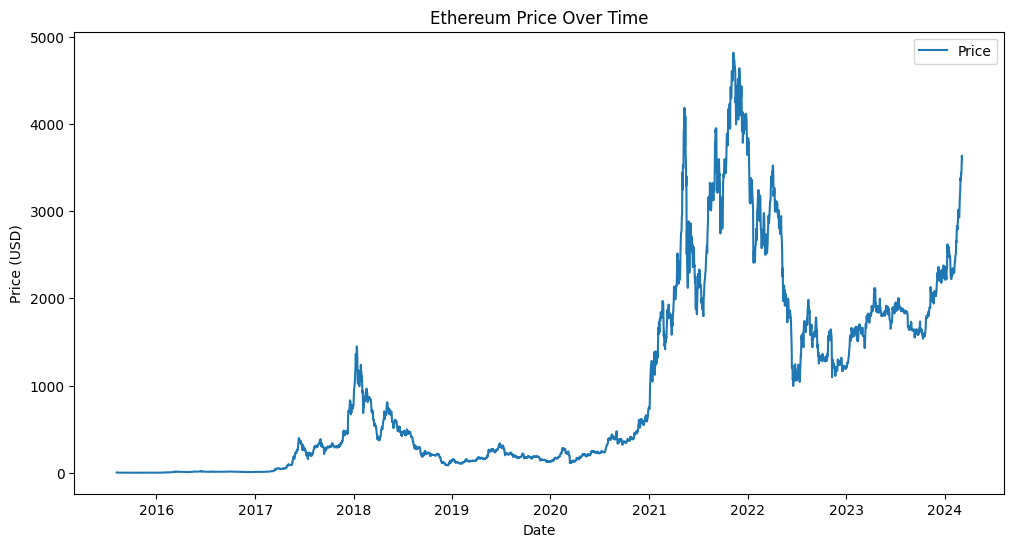

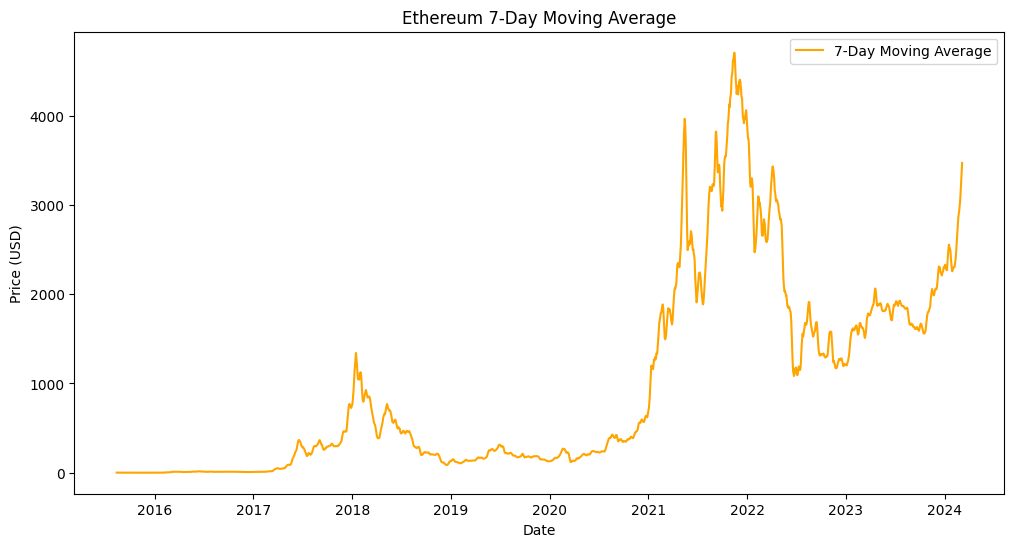

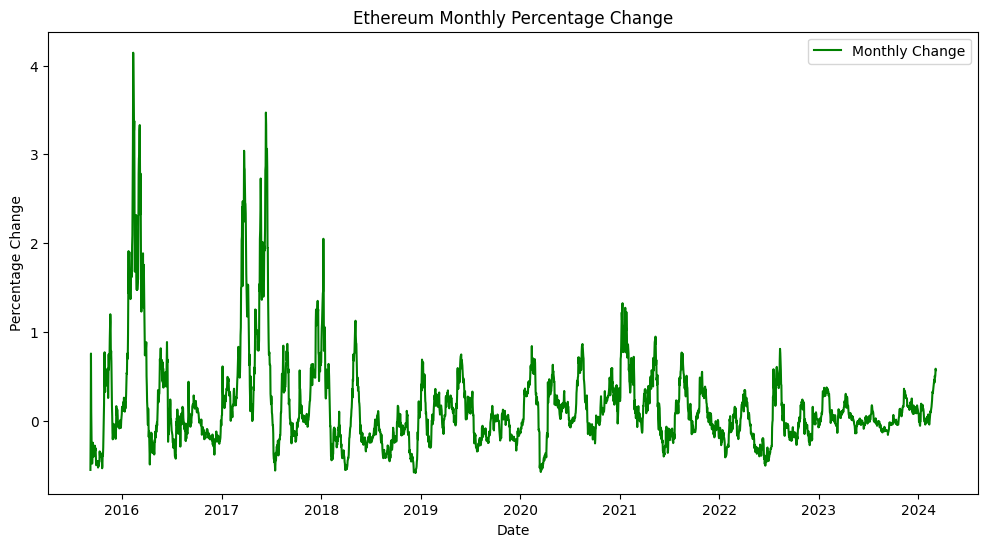

Analyzing tether...


C:\Users\samin\AppData\Local\Temp\ipykernel_10920\3460888346.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill to handle missing values


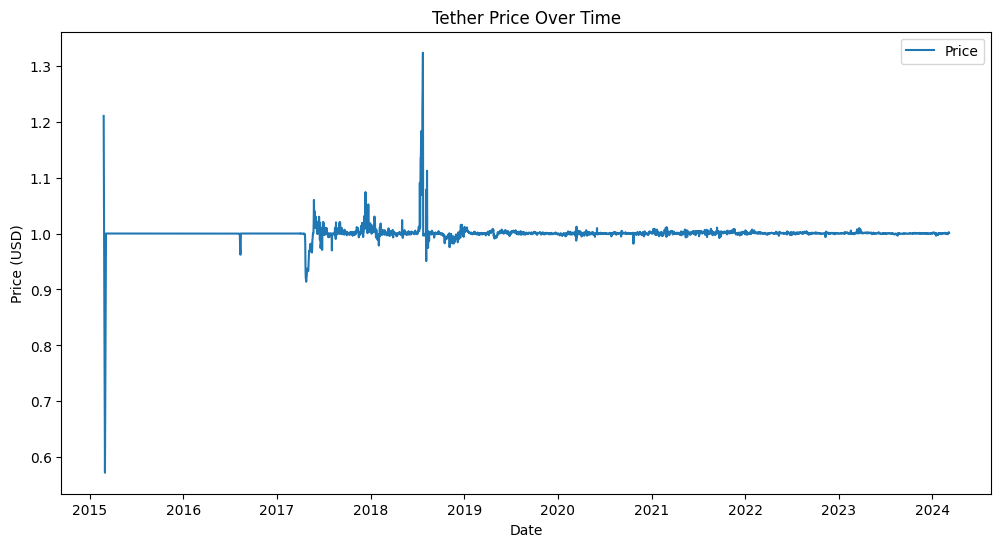

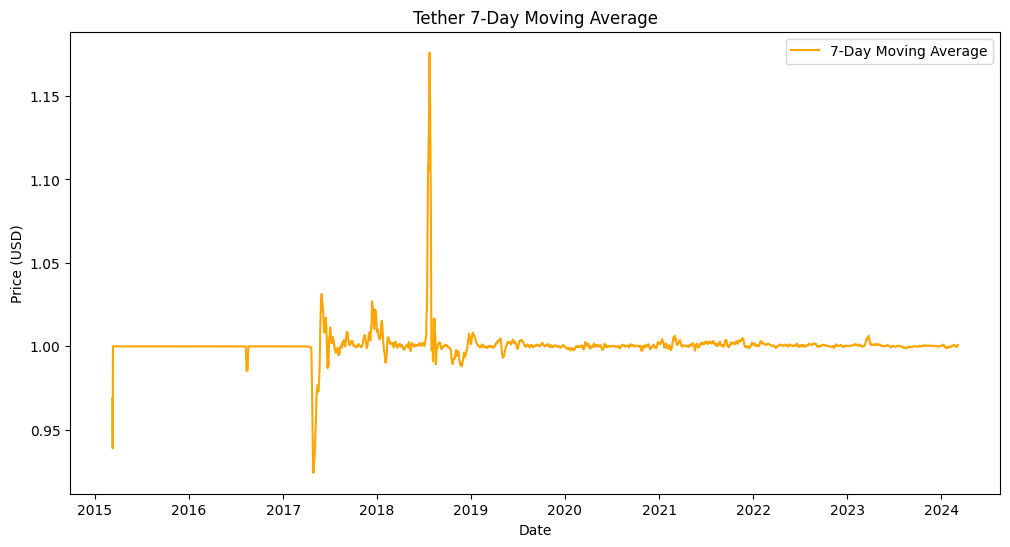

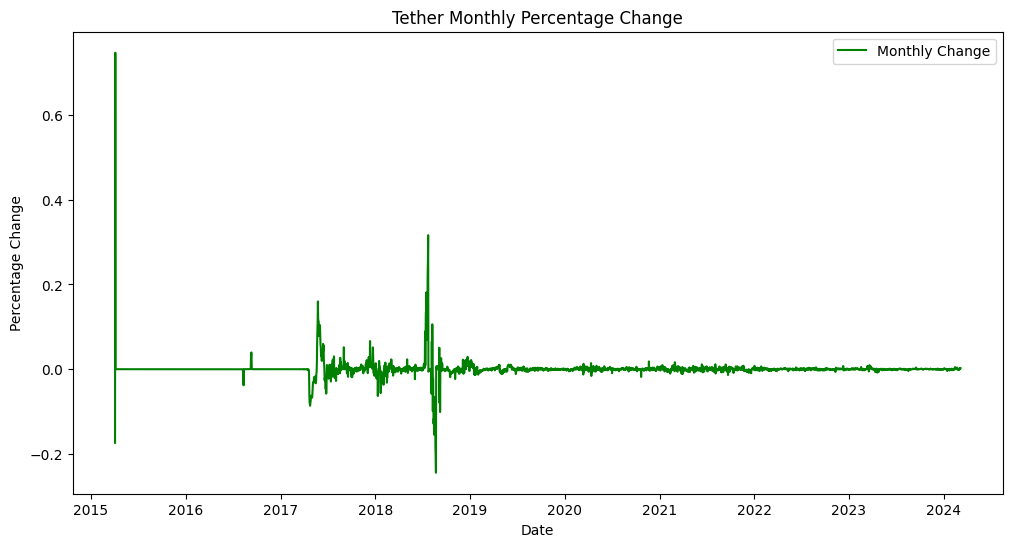

Analyzing binancecoin...


C:\Users\samin\AppData\Local\Temp\ipykernel_10920\3460888346.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill to handle missing values


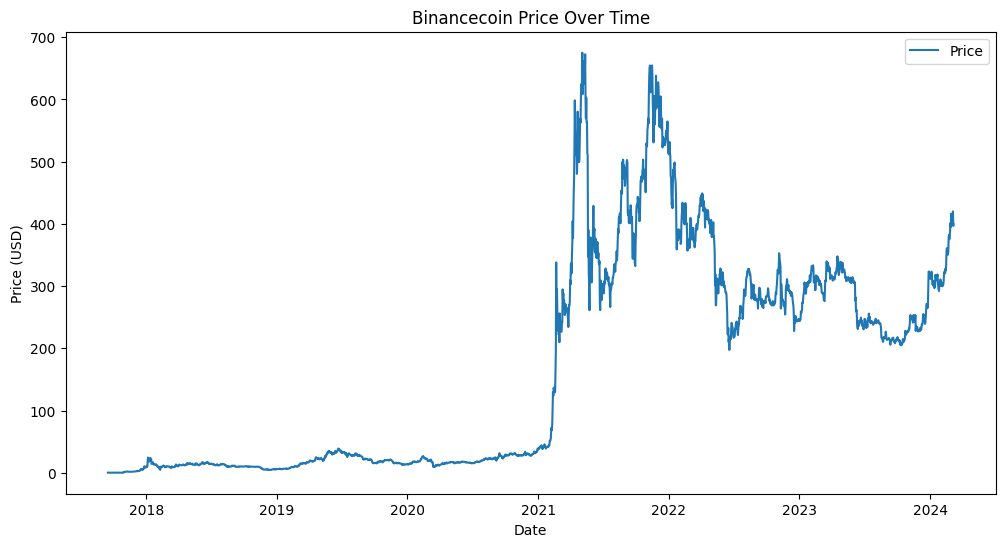

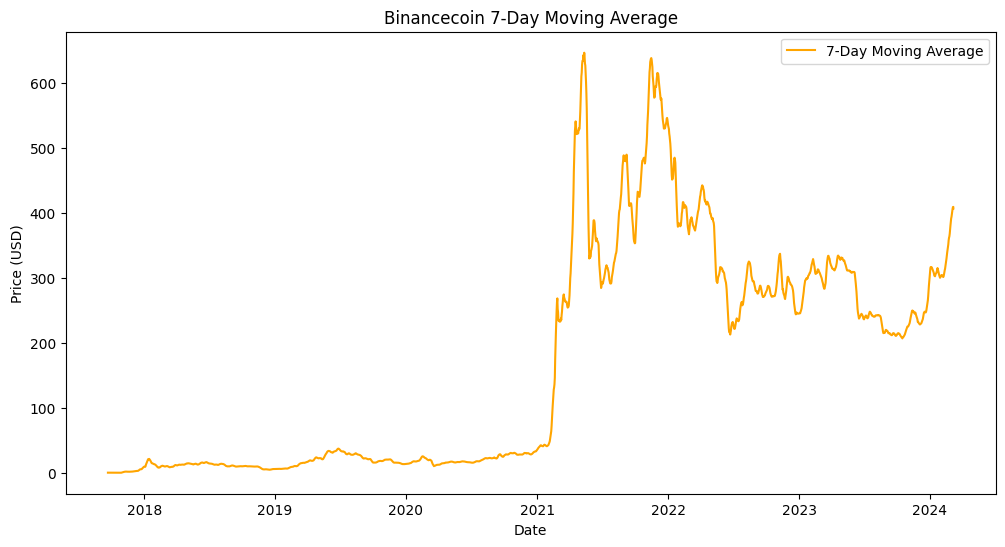

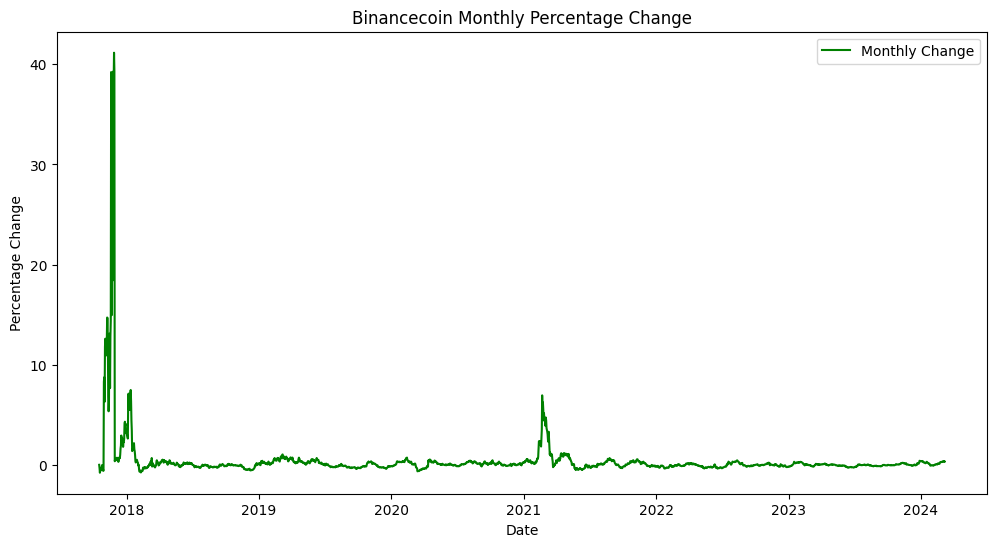

Analyzing solana...


C:\Users\samin\AppData\Local\Temp\ipykernel_10920\3460888346.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill to handle missing values


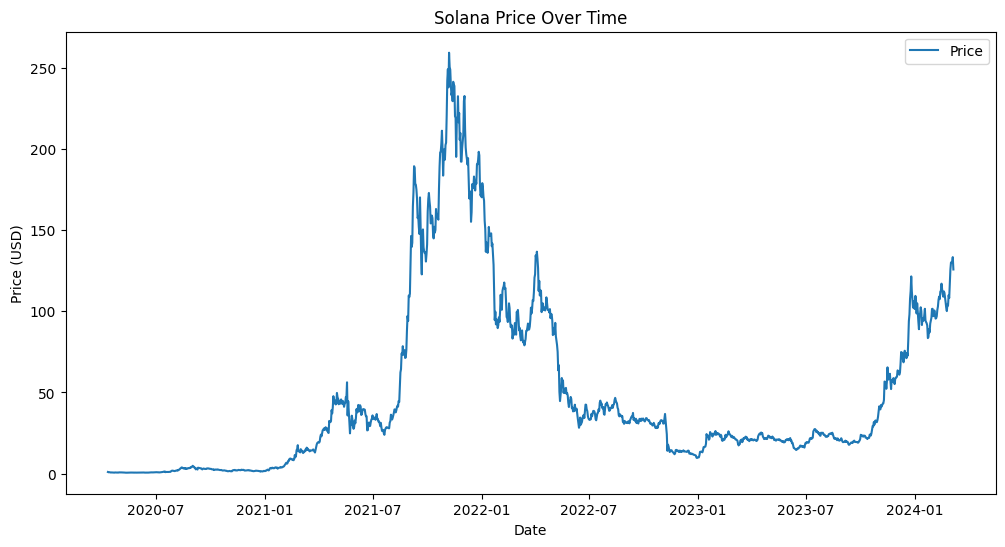

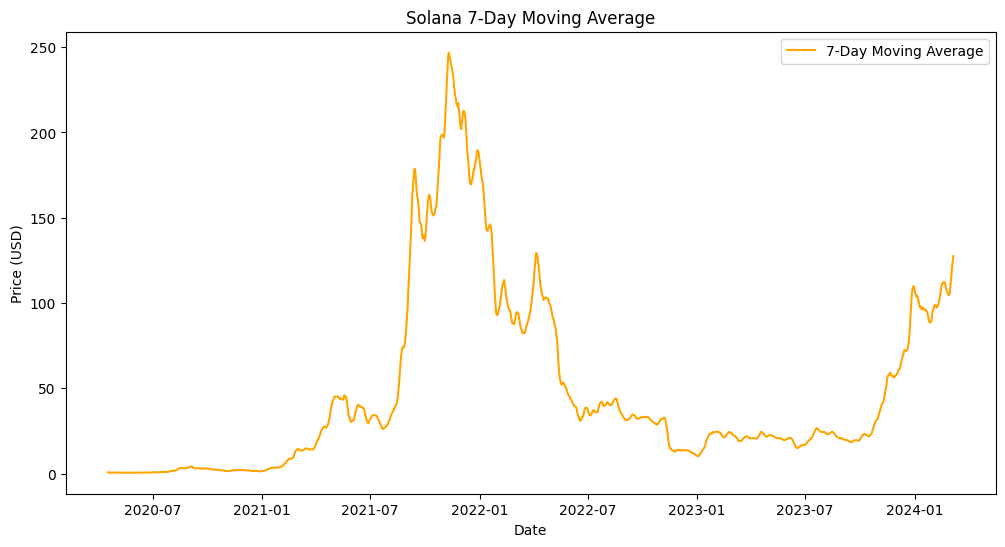

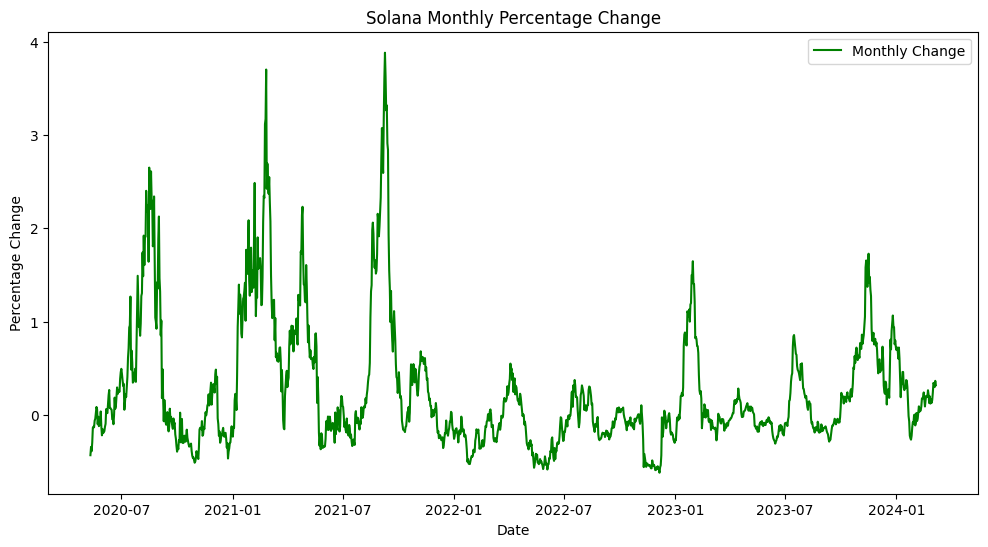

## ARIMA Model for Time Series Forecasting

In this step, we employ the ARIMA (AutoRegressive Integrated Moving Average) model for time series forecasting of cryptocurrency prices:

- **Model Definition**: We define an ARIMA model with the order (5,1,2), where 5 is the number of autoregressive terms, 1 is the number of differences used to make the time series stationary, and 2 is the number of moving average terms.
- **Model Fitting**: The model is fitted to the historical price data of the cryptocurrency. The fitting process involves finding the best parameters for the ARIMA model that minimize the forecasting error.
- **Model Summary**: We print the summary of the fitted model, which includes information about the model's coefficients, standard errors, and statistical significance. This summary helps us understand the relationship between the current price and its lagged values, as well as the model's overall fit.

The ARIMA model provides a statistical approach to time series forecasting, complementing the deep learning methods used earlier in the project.


In [24]:
# Example using ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# Define and fit the model
model = ARIMA(df['price'], order=(5,1,2))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())


c:\Users\samin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\samin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\samin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 1426
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -4016.247
Date:                Tue, 05 Mar 2024   AIC                           8048.494
Time:                        23:51:07   BIC                           8090.590
Sample:                             0   HQIC                          8064.216
                               - 1426                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3344      0.033    -39.937      0.000      -1.400      -1.269
ar.L2         -0.7533      0.032    -23.335      0.000      -0.817      -0.690
ar.L3          0.0779      0.022      3.550      0.0

## ARIMA Model Predictions and Evaluation

In this step, we use the fitted ARIMA model to make predictions and evaluate its performance:

- **Making Predictions**: We use the `forecast` method of the fitted ARIMA model to predict the cryptocurrency prices for the next 30 days. The `steps` parameter specifies the number of future time steps to predict.
- **Evaluation Metrics**: To assess the accuracy of the model's predictions, we calculate the Mean Squared Error (MSE) between the predicted prices and the actual prices for the last 30 days of the dataset. The MSE provides a quantitative measure of the model's forecasting error.
- **Printing Results**: The calculated MSE is printed to provide a summary of the model's performance. A lower MSE indicates better prediction accuracy.

By evaluating the ARIMA model's predictions using the MSE metric, we can gauge its effectiveness in forecasting cryptocurrency prices and compare its performance to other models used in the project.


In [25]:
# Make predictions
predictions = model_fit.forecast(steps=30)  # Predict the next 30 days

# Calculate and print evaluation metrics
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(df['price'][-30:], predictions)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 290.22159126367427


c:\Users\samin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\samin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## Plotting ARIMA Model Predictions

In this step, we visualize the predictions made by the ARIMA model alongside the historical price data:

- **Historical Prices**: We plot the historical prices of the cryptocurrency using a line plot. This provides a reference for comparing the model's predictions against actual price movements.
- **Predictions**: We plot the ARIMA model's predictions for the next 30 days using a red line plot. The predictions are aligned with the time axis by creating a date range starting from the last date in the historical data.
- **Plot Customization**: The plot is customized with a title indicating the cryptocurrency being analyzed, labels for the x-axis (date) and y-axis (price), and a legend to distinguish between historical prices and predictions.

We create separate plots for each cryptocurrency (e.g., Bitcoin and Ethereum) to visually assess the accuracy of the ARIMA model's forecasts for different assets.

By plotting the model's predictions, we can visually evaluate its performance and identify areas where the model may be overestimating or underestimating future price movements.


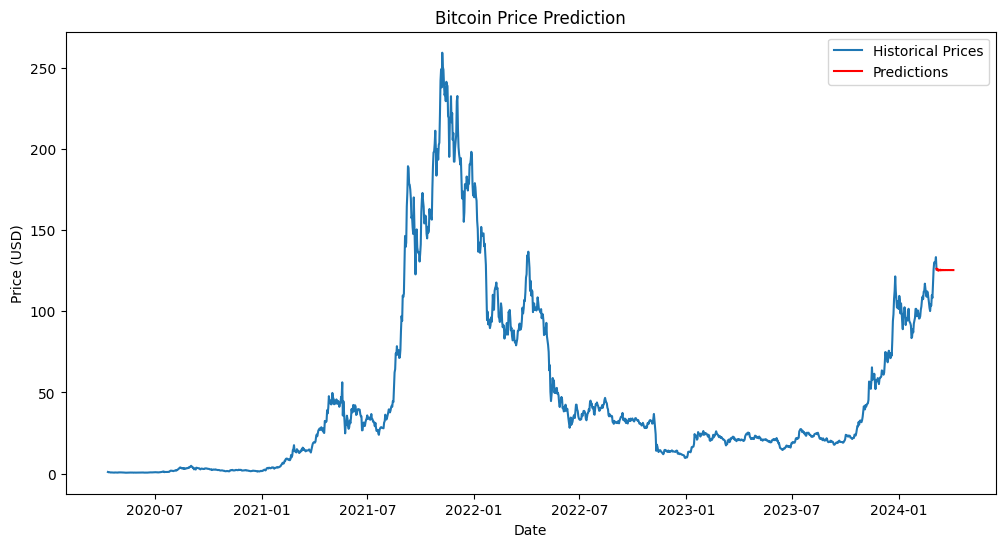

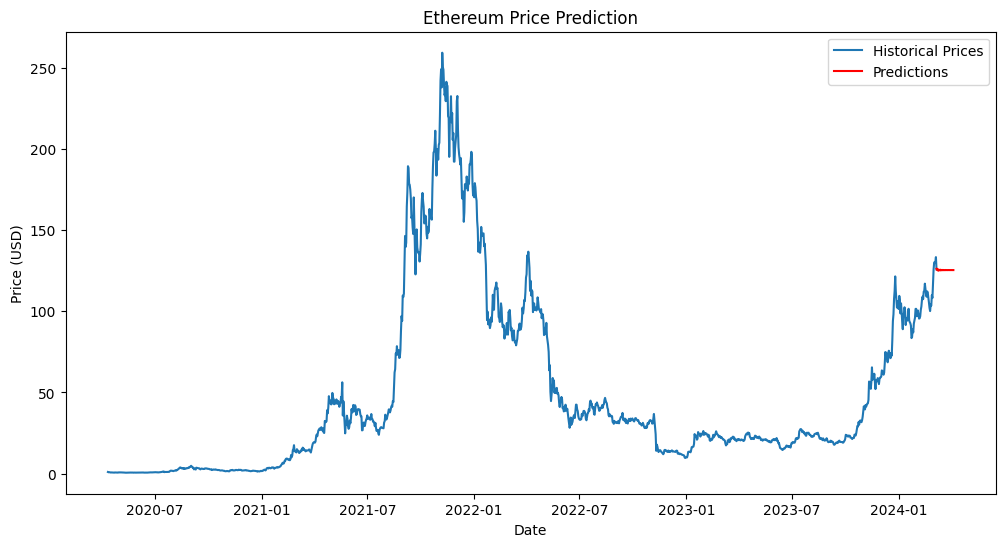

In [26]:
# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['price'], label='Historical Prices')
plt.plot(pd.date_range(df.index[-1], periods=len(predictions), freq='D'), predictions, label='Predictions', color='red')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['price'], label='Historical Prices')
plt.plot(pd.date_range(df.index[-1], periods=len(predictions), freq='D'), predictions, label='Predictions', color='red')
plt.title('Ethereum Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


Epoch 1/10
34/34 - 10s - loss: 0.0195 - 10s/epoch - 294ms/step
Epoch 2/10
34/34 - 2s - loss: 0.0020 - 2s/epoch - 47ms/step
Epoch 3/10
34/34 - 2s - loss: 0.0019 - 2s/epoch - 56ms/step
Epoch 4/10
34/34 - 2s - loss: 0.0017 - 2s/epoch - 54ms/step
Epoch 5/10
34/34 - 2s - loss: 0.0014 - 2s/epoch - 56ms/step
Epoch 6/10
34/34 - 2s - loss: 0.0015 - 2s/epoch - 57ms/step
Epoch 7/10
34/34 - 2s - loss: 0.0013 - 2s/epoch - 62ms/step
Epoch 8/10
34/34 - 2s - loss: 0.0012 - 2s/epoch - 53ms/step
Epoch 9/10
34/34 - 2s - loss: 0.0013 - 2s/epoch - 50ms/step
Epoch 10/10
34/34 - 2s - loss: 0.0012 - 2s/epoch - 56ms/step
8/8 [==============================] - 0s 20ms/step


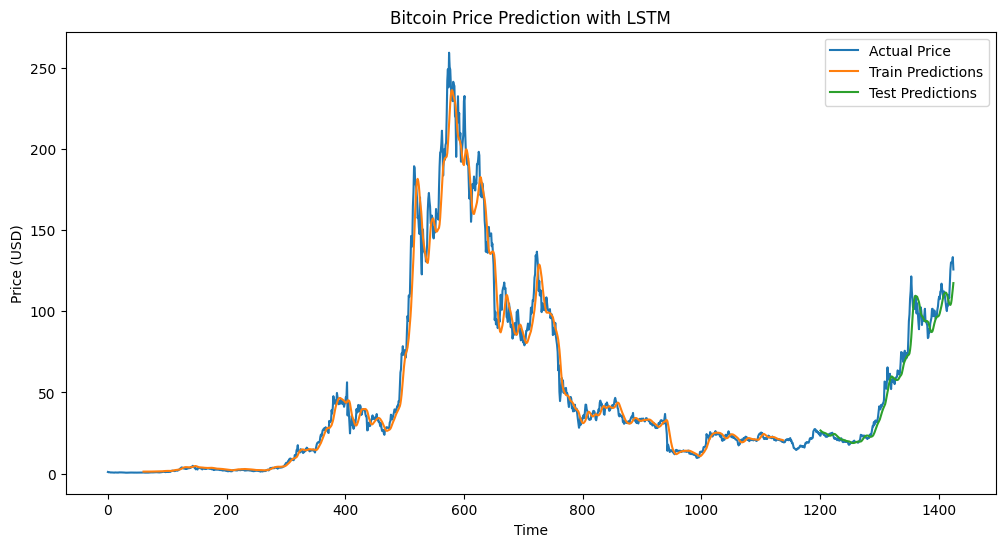

In [27]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Assuming 'df' is your preprocessed DataFrame with the 'price' column

# Convert the DataFrame to a numpy array
data = df['price'].values.reshape(-1, 1)

# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

# Create the training and testing datasets
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60  # Number of previous time steps to consider for predicting the next time step
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=2)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data, label='Actual Price')
plt.plot(np.arange(look_back, look_back + len(train_predict)), train_predict, label='Train Predictions')
plt.plot(np.arange(len(data) - len(test_predict), len(data)), test_predict, label='Test Predictions')
plt.title('Bitcoin Price Prediction with LSTM')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


## LSTM Model for Time Series Forecasting

In this step, we build and train an LSTM (Long Short-Term Memory) model for forecasting cryptocurrency prices:

- **Data Preparation**:
    - The price data is converted to a numpy array and normalized using the MinMaxScaler to ensure efficient training.
    - The data is split into training and testing sets, with 80% of the data used for training.
    - We create sequences of historical prices (`X`) and the corresponding next price (`Y`) for both the training and testing sets, using a specified `look_back` period.

- **Model Building**:
    - An LSTM model is constructed with two LSTM layers and a dense output layer.
    - The model is compiled with the mean squared error loss function and the Adam optimizer.

- **Model Training**:
    - The model is trained on the training data for a specified number of epochs and batch size.

- **Making Predictions**:
    - The model is used to make predictions on both the training and testing sets.
    - The predictions are scaled back to the original price range for comparison with actual prices.

- **Visualization**:
    - A plot is created to visualize the actual prices and the model's predictions on both the training and testing sets.
    - This visualization helps assess the model's performance and its ability to capture price trends.

By employing an LSTM model, we leverage its ability to learn from sequences of data and make predictions about future price movements based on historical trends.


## Conclusion

In this project, we explored the application of time series forecasting and deep learning techniques to predict cryptocurrency prices. We focused on analyzing historical price data for several cryptocurrencies, including Bitcoin, Ethereum, Tether, Binance Coin, and Solana.

Key takeaways from this project include:

- **Data Preprocessing**: Proper preprocessing of the time series data, including handling missing values, feature engineering, and normalization, is crucial for effective model training and prediction accuracy.
- **Exploratory Data Analysis**: Visualizing the historical price data and derived features, such as moving averages and percentage changes, provided valuable insights into the market trends and volatility of different cryptocurrencies.
- **ARIMA Model**: The ARIMA model served as a statistical approach to time series forecasting, providing a baseline for evaluating the performance of more complex models.
- **LSTM Model**: The LSTM neural network model demonstrated its potential in capturing the sequential nature of time series data and making predictions about future price movements. The model's performance was evaluated using the Mean Squared Error (MSE) metric, and the predictions were visualized alongside the actual prices to assess the model's accuracy.

Overall, while the LSTM model showed promise in forecasting cryptocurrency prices, it's important to note that the cryptocurrency market is highly volatile and influenced by numerous external factors. Therefore, the predictions made by the model should be interpreted with caution and not be solely relied upon for investment decisions.

Future work in this area could involve exploring different model architectures, incorporating additional features such as trading volume and sentiment analysis, and testing the models on a broader range of cryptocurrencies to further improve prediction accuracy and reliability.
